In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Loading functions
import os
import time
from monai.data import DataLoader, decollate_batch


import torch
import torch.nn.parallel

from src.get_data import CustomDataset, CustomDatasetSeg
import numpy as np
from scipy import ndimage
from types import SimpleNamespace
import wandb
import logging

#####
import json
import shutil
import tempfile

import matplotlib.pyplot as plt
import nibabel as nib

from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai import transforms
from monai.transforms import (
    AsDiscrete,
    Activations,
    MapTransform,
    Transform,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.utils.enums import MetricReduction
from monai.networks.nets import SwinUNETR
from monai import data

# from monai.data import decollate_batch
from functools import partial
from src.custom_transforms import ConvertToMultiChannelBasedOnBratsClassesdI, ConvertToMultiChannelBasedOnAnotatedInfiltration, masked



In [45]:
from src.get_data import combine_labels_recurrence
# Combinar labels
# Ejemplo de uso
caso='00355'
# path_label1 = f'./Dataset/Dataset_10_1_casos/train_all/labels/UPENN-GBM-{caso}_11_automated_approx_segm.nii.gz'
# path_label2 = f'./Dataset/Dataset_10_1_casos/train_all/labels/UPENN-GBM-{caso}_11_combined_approx_segm.nii.gz'
# output_path = f'./Dataset/Dataset_10_1_casos/train_all/labels/UPENN-GBM-{caso}_11_combined2_approx_segm.nii.gz'

path_label1 = f'./Dataset/Dataset_recurrence/train/labels/UPENN-GBM-{caso}_11_automated_approx_segm.nii.gz'
path_label2 = f'./Dataset/Dataset_recurrence/train/labels/UPENN-GBM-{caso}_11_combined2_approx_segm.nii.gz'
output_path = f'./Dataset/Dataset_recurrence/train/temp/UPENN-GBM-{caso}_11_combined3_approx_segm.nii.gz'

combine_labels_recurrence(path_label1, path_label2, output_path)

[0. 1. 2. 4.]
[0.         2.00000004 6.00000012]


In [3]:
roi = (128, 128, 128) # (220, 220, 155) (128, 128, 64)
source_k="label"
train_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        # ConvertToMultiChannelBasedOnN_Froi(keys="label"),
        # masked(keys="image"),
        ConvertToMultiChannelBasedOnAnotatedInfiltration(keys="label"),
        # ConvertToMultiChannelBasedOnBratsClassesdI(keys="label"),
        transforms.CropForegroundd(
            keys=["image", "label"],
            source_key=source_k,
            k_divisible=[roi[0], roi[1], roi[2]],
        ),
        transforms.RandSpatialCropd(
            keys=["image", "label"],
            roi_size=[roi[0], roi[1], roi[2]],
            random_size=False,
        ),
        transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        transforms.RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        transforms.RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        
    ]
)
val_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        # ConvertToMultiChannelBasedOnN_Froi(keys="label"),
        # masked(keys="image"),
        ConvertToMultiChannelBasedOnAnotatedInfiltration(keys="label"),
        # ConvertToMultiChannelBasedOnBratsClassesdI(keys="label"),
        transforms.RandSpatialCropd(
            keys=["image", "label"],
            roi_size=[-1, -1, -1], #[240, 240, 155],
            random_size=False,
        ),
        transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)


/home/training2/miniconda3/envs/monai_env/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [6]:
# dataset_path='./Dataset/Dataset_331_30_casos/'
dataset_path='./Dataset/Dataset_recurrence'

train_set=CustomDataset(dataset_path, section="train",transform=train_transform) # t_transform
train_loader = DataLoader(train_set, batch_size=1, shuffle=True, num_workers=1, pin_memory=False)

im_t=train_set[0]

val_set=CustomDataset(dataset_path, section="train", transform=val_transform) # v_transform
val_loader = DataLoader(val_set, batch_size=1, shuffle=False, num_workers=1, pin_memory=False)

im_v=val_set[0]

print(im_t['image'].shape, type(im_t['image']))
print(im_t['label'].shape, type(im_t['label']))
print(im_v['image'].shape, type(im_v['image']))
print(im_v['label'].shape, type(im_v['label']))

Found 36 images and 36 labels.
Found 36 images and 36 labels.
torch.Size([11, 128, 128, 128]) <class 'monai.data.meta_tensor.MetaTensor'>
torch.Size([2, 128, 128, 128]) <class 'monai.data.meta_tensor.MetaTensor'>
torch.Size([11, 240, 240, 155]) <class 'monai.data.meta_tensor.MetaTensor'>
torch.Size([2, 240, 240, 155]) <class 'monai.data.meta_tensor.MetaTensor'>


In [18]:
for idx, batch_data in enumerate(val_loader):
    if idx == 5:  # Cambia 0 al índice del batch deseado
        val_data_example=batch_data
        data, target = batch_data["image"], batch_data["label"]
        print(data.shape)
        print(target.shape)
        break
        


torch.Size([1, 11, 240, 240, 155])
torch.Size([1, 2, 240, 240, 155])


image shape: torch.Size([1, 11, 240, 240, 155]) <class 'monai.data.meta_tensor.MetaTensor'>


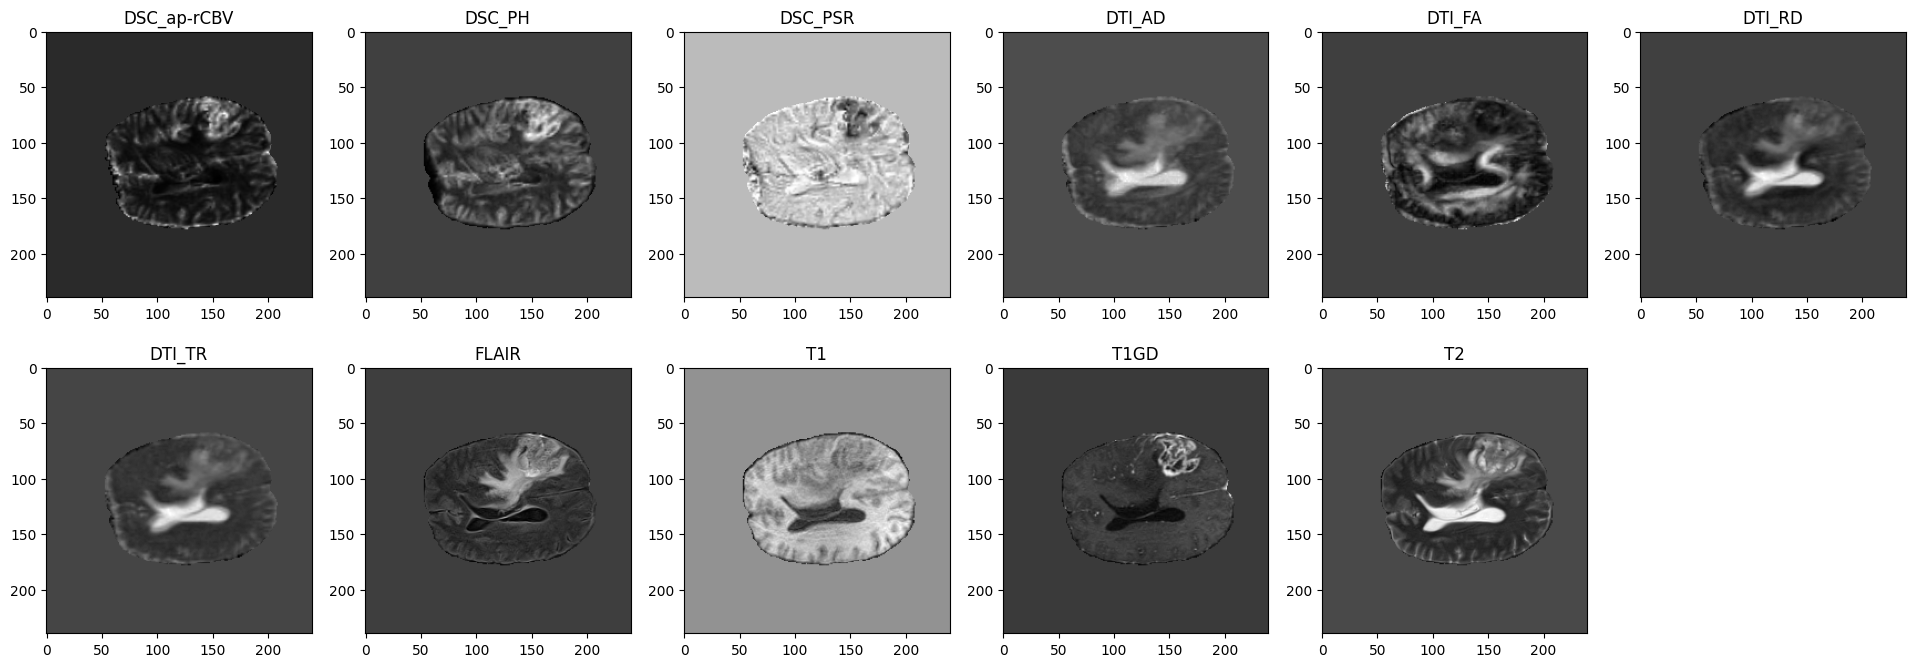

label shape: torch.Size([1, 2, 240, 240, 155]) <class 'monai.data.meta_tensor.MetaTensor'>


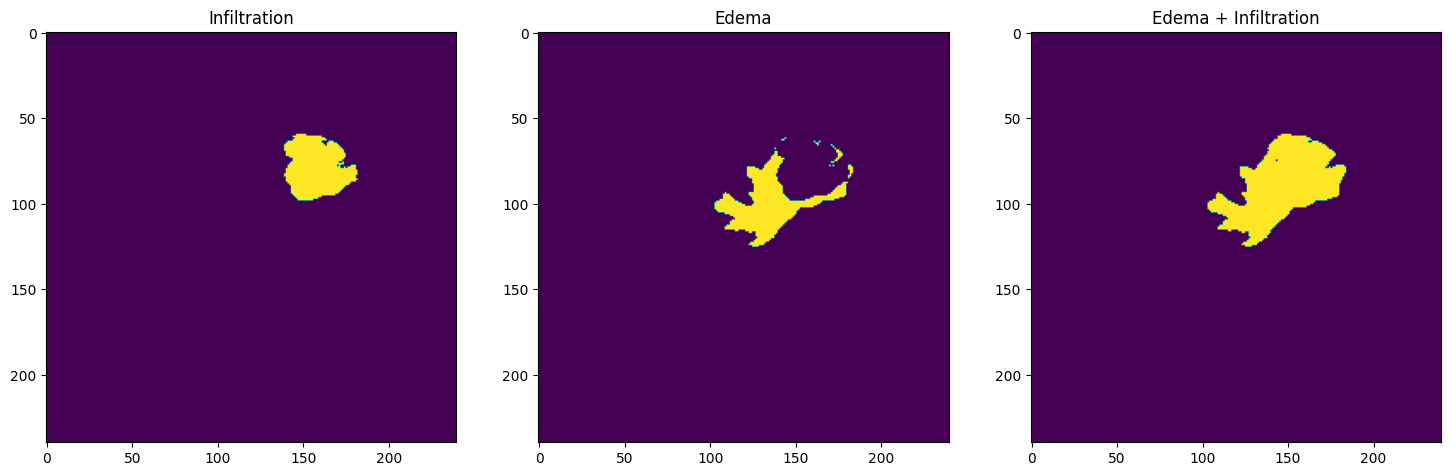

In [20]:
# pick one image from DecathlonDataset to visualize and check the 4 channels
# N_ROI -> hatsa 0.5cm alrededor del TC
# F_ROI -> entre 1 y 4 cm alrededor del TC
nombres=["DSC_ap-rCBV","DSC_PH", "DSC_PSR", "DTI_AD", "DTI_FA", "DTI_RD", "DTI_TR", "FLAIR", "T1", "T1GD", "T2",]
#val_data_example = train_set[60]
sl=90 #70 32
print(f"image shape: {val_data_example['image'].shape}", type(val_data_example['image']))
plt.figure("image", (24, 8))
for i in range(11):
    plt.subplot(2, 6, i + 1)
    plt.title(nombres[i])
    plt.imshow(val_data_example["image"][0][i, :, :, sl].cpu(), cmap="gray") # .detach()
plt.show()
# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_data_example['label'].shape}", type(val_data_example['label']))
plt.figure("label", (18, 6))
# my_title=['N_ROI (0-5mm)', 'F_ROI (+10mm)', 'N_ROI + F_ROI']
my_title=['Infiltration', 'Edema', 'Edema + Infiltration']
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"{my_title[i]}")
    if i<2:
        plt.imshow(val_data_example["label"][0][i, :, :, sl].cpu()) # .detach()
    else:
        #plt.imshow(val_data_example["label"][i, :, :, sl].detach().cpu())
        im_show=torch.from_numpy(np.logical_or(val_data_example["label"][0][0, :, :, sl], val_data_example["label"][0][1, :, :, sl])) # torch.from_numpy
        plt.imshow((im_show).cpu()) # .detach()

plt.show()

## Hacer inferencia con los modelos y visualizar

In [ ]:
######################
# Crear el modelo
######################

### Hyperparameter
roi = (128, 128, 128)  # (128, 128, 128)

# Create Swin transformer
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=roi,
    in_channels=11,
    out_channels=2,  # mdificar con edema
    feature_size=48, #48
    drop_rate=0.0,
    attn_drop_rate=0.0,
    dropout_path_rate=0.0,
    use_checkpoint=True,
)

In [ ]:
#############################
### Trar modelo desde WandB
#############################

# mlops-team89/Swin_UPENN/93rp3g83_best_model:v0  -> cerebro_nroi+froi
# mlops-team89/Swin_UPENN/sq1r37ci_best_model:v0  -> cerebro_nroi+froi+edema

run = wandb.init()
artifact = run.use_artifact('mlops-team89/Swin_UPENN_106cases/8fhm3ha5_best_model:v0', type='model')
artifact_dir = artifact.download()
print(artifact_dir)

In [17]:
#model.load_state_dict(torch.load(os.path.join(artifact_dir, "model.pt"), map_location=torch.device('cpu')))

#model_path = os.path.join(artifact_dir, "model.pt")
model_path = "artifacts/ddfkhvym_best_model:v0/model.pt"

# Load the model on CPU
loaded_model = torch.load(model_path, map_location=torch.device('cuda:0'))["state_dict"]

# Load the state dictionary into the model
model.load_state_dict(loaded_model)

# Move the model to the desired device (e.g., GPU) if available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set the model to evaluation mode
model.eval()


SwinUNETR(
  (swinViT): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(11, 48, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers1): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0-1): 2 x SwinTransformerBlock(
            (norm1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=48, out_features=144, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=48, out_features=48, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
            (mlp): MLPBlock(
              (linear1): Linear(in_features=48, out_features=192, bias=True)
              (linear2): Linear(in_featur

In [18]:
dataset_path='./Dataset/Dataset_recurrence'
train_set=CustomDataset(dataset_path, section="test", transform=train_transform) # v_transform
train_loader = DataLoader(train_set, batch_size=1, shuffle=False, num_workers=1)

Found 1 images and 1 labels.


## Guardar embeddings de cada voxel

In [ ]:
embedding_dir = "Dataset/embeddings"
label_output_dir = "Dataset/labels"

# Crear carpetas si no existen
os.makedirs(embedding_dir, exist_ok=True)
os.makedirs(label_output_dir, exist_ok=True)

# Variable para las características del decoder
decoder_features = None

# Función hook
def decoder_hook_fn(module, input, output):
    global decoder_features
    decoder_features = output

# Registrar el hook en decoder1.conv_block
hook_handle_decoder = model.decoder1.conv_block.register_forward_hook(decoder_hook_fn)

# Extraer embeddings y etiquetas voxel-wise
with torch.no_grad():
    for idx, batch_data in enumerate(train_loader):
        # val_data_example=batch_data
        image, label = batch_data["image"], batch_data["label"]
        print("Image",image.shape)
        print("label before squeeze",label.shape)
        image = image.to(device)  # MRI (1, 11, D, H, W)
        label = label.squeeze(0).cpu().numpy()  # Etiquetas (D, H, W)
        print("label", label.shape)

        # Obtener los embeddings de cada voxel desde el decoder de Swin UNETR
        features = model(image)  # Salida: lista de características de cada etapa
        
        print("features:", features.shape)

        # Guardar embeddings y etiquetas
        np.save(f"{embedding_dir}/case_{idx}.npy", features)
        np.save(f"{label_output_dir}/case_{idx}.npy", label)

        print(f"Guardado embeddings y etiquetas para caso {idx}")
        
print("Forma de las características del decoder:", decoder_features.shape)

# Remover el hook
hook_handle_decoder.remove()

Image torch.Size([1, 11, 128, 128, 64])
label before squeeze torch.Size([1, 2, 128, 128, 64])
label (2, 128, 128, 64)
features: torch.Size([1, 2, 128, 128, 64])
Guardado embeddings y etiquetas para caso 0
Forma de las características del decoder: torch.Size([1, 48, 128, 128, 64])


## Funciones para la inferencia

In [15]:
def inference(input, model, VAL_AMP=False):
    # if config_train.use_autocast:
    #    VAL_AMP = True
    # else:
    #    VAL_AMP = False

    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(224, 224, 128),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)
    
roi_t= (224, 224, 128)
model_inferer_test = partial(
    sliding_window_inference,
    roi_size=[roi_t[0], roi_t[1], roi_t[2]],
    sw_batch_size=1,
    predictor=model,
    overlap=0.6,
)            

In [16]:
def imprimir_inferencia(serie, seg_out, seg, slice, recurrence=False):
    slice_num = slice
    if recurrence:
        s=2
        Path=os.path.join("./Dataset",
                          f"Dataset_106_30_casos/test/images/images_structural/UPENN-GBM-{serie}_11/UPENN-GBM-{serie}_11_T1GD.nii.gz")
        Path_recurrence =os.path.join("./Dataset",
                          f"Dataset_106_30_casos/recurrence/images_structural/UPENN-GBM-{serie}_21/UPENN-GBM-{serie}_21_T1GD.nii.gz")
    else:
        s=1
        Path=os.path.join("./Dataset",
                          f"Dataset_106_30_casos/test/images/images_structural/UPENN-GBM-{serie}_{s}1/UPENN-GBM-{serie}_{s}1_T1GD.nii.gz")

    img_add = Path
    if recurrence:
        img_rec = Path_recurrence
    
    label_add = os.path.join(
            "./Dataset",
            f"Dataset_106_30_casos/test/labels/UPENN-GBM-{serie}_11_segm.nii.gz",
        )
    if not os.path.exists(label_add):
        label_add = os.path.join(
            "./Dataset",
            f"Dataset_106_30_casos/test/labels/UPENN-GBM-{serie}_11_automated_approx_segm.nii.gz",
        )

    img = nib.load(img_add).get_fdata()
    if recurrence:
        img_rec = nib.load(img_rec).get_fdata()

    label = nib.load(label_add).get_fdata()

    plt.figure("image", (18, 18))

    plt.subplot(3, 3, 1)
    plt.title("image")
    plt.imshow(img[:, :, slice_num], cmap="gray")

    plt.subplot(3, 3, 2)
    plt.title("label")
    plt.imshow(label[:, :, slice_num])

    plt.subplot(3, 3, 3)
    #plt.title("image")
    plt.imshow(img[:, :, slice_num], cmap="gray")

    plt.subplot(3, 3, 3)
    plt.title("nroi - froi - inter.")
    plt.imshow(seg_out[:, :, slice_num], cmap='jet', alpha=0.5) #, cmap='jet'

    plt.subplot(3, 3, 4)
    plt.title("Map nroi")
    plt.imshow(seg[0][:, :, slice_num])

    plt.subplot(3, 3, 5)
    plt.title("Map froi")
    plt.imshow(seg[1][:, :, slice_num])

    if recurrence:
        plt.subplot(3, 3, 6)
        plt.title("image_recurrence")
        plt.imshow(img_rec[:, :, slice_num], cmap="gray")

    plt.show()

In [21]:
n = 8
slice = 70
# cases =['00036', '00042','00045', '00051' ]
cases = [
    36,
    42,
    45,
    51,
    52,
    55,
    84,
    86,
    88,
    122,
    128,
    129,
    133,
    134,
    140,
    141,
    145,
    148,
    150,
    160,
    183,
    197,
    219,
    267,
    285,
    295,
    301,
    302,
    307,
    312,
    314,
    332,
    352,
    353,
    354,
    355,
]

In [ ]:

with torch.no_grad():
    for i, batch_data in enumerate(train_loader):
        if i == n:
            image = batch_data["image"].to('cpu')
            logit=model_inferer_test(image) #inference / model_inferer_test
            prob_sig = torch.sigmoid(logit)
            seg = prob_sig[0].detach().cpu().numpy()

            #seg = (seg > 0.5).astype(np.int8)
            #seg_prob_map = seg[0]
            #seg_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))
            #seg_out[seg[1] == 1] = 1
            #seg_out[seg[0] == 1] = 2
            # seg_out[seg[2] == 1] = 4

            seg = prob_sig[0].detach().cpu().numpy()
            seg1 = (seg > 0.9).astype(np.int8)
            seg_out = np.zeros((seg1.shape[1], seg1.shape[2], seg1.shape[3]))
            seg_out[seg1[1] == 1] = 1
            seg_out[seg1[0] == 1] = 3

            # Nueva línea para la intersección utilizando 'and'
            seg_out[(seg1[0] == 1) & (seg1[1] == 1)] = 2

            # Imprimir
            serie= cases[n]
            # Guardar el valor de la variable en un archivo
            np.save(f'trained_models/seg_{str(serie).zfill(5)}.npy', seg)
            np.save(f'trained_models/seg_out_{str(serie).zfill(5)}.npy', seg_out)

            # Imprimir
            imprimir_inferencia(f'{str(serie).zfill(5)}', seg_out, seg, slice=slice, recurrence=True)
            break
        #i+=1

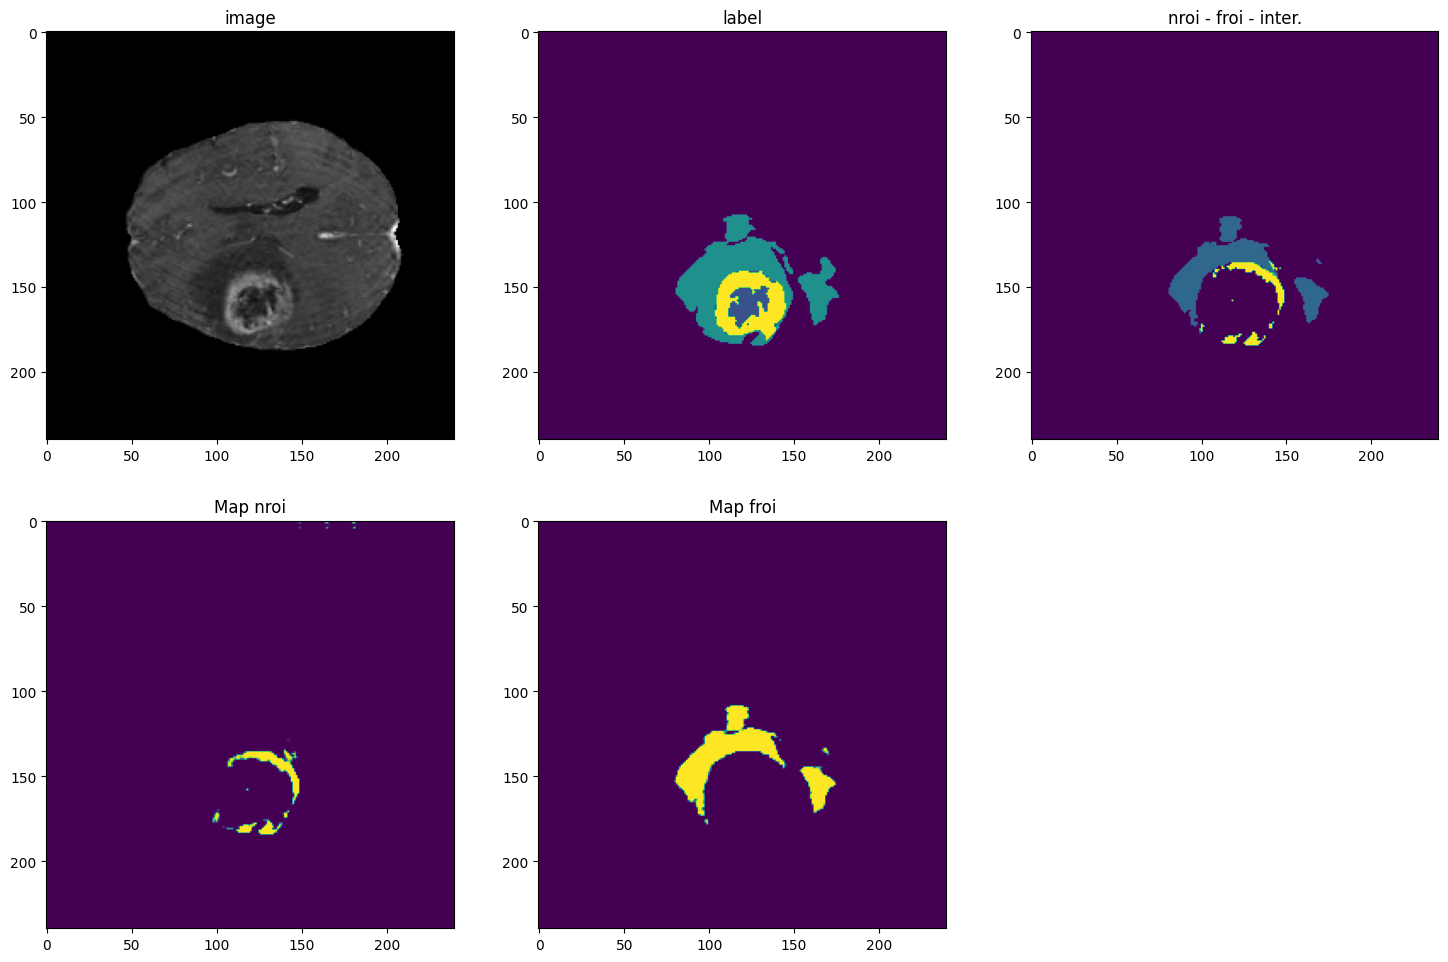

In [15]:
# Imprimir
# cases =['00036', '00042','00045', '00051' ]
n=7
slice = 90
serie=cases[n]
seg_out = np.load(f'trained_models/seg_out_{str(serie).zfill(5)}.npy')
seg = np.load(f'trained_models/seg_{str(serie).zfill(5)}.npy')
imprimir_inferencia(f'{str(serie).zfill(5)}', seg_out, seg, slice=slice)

## Visualizar con imagenes de recurrencia

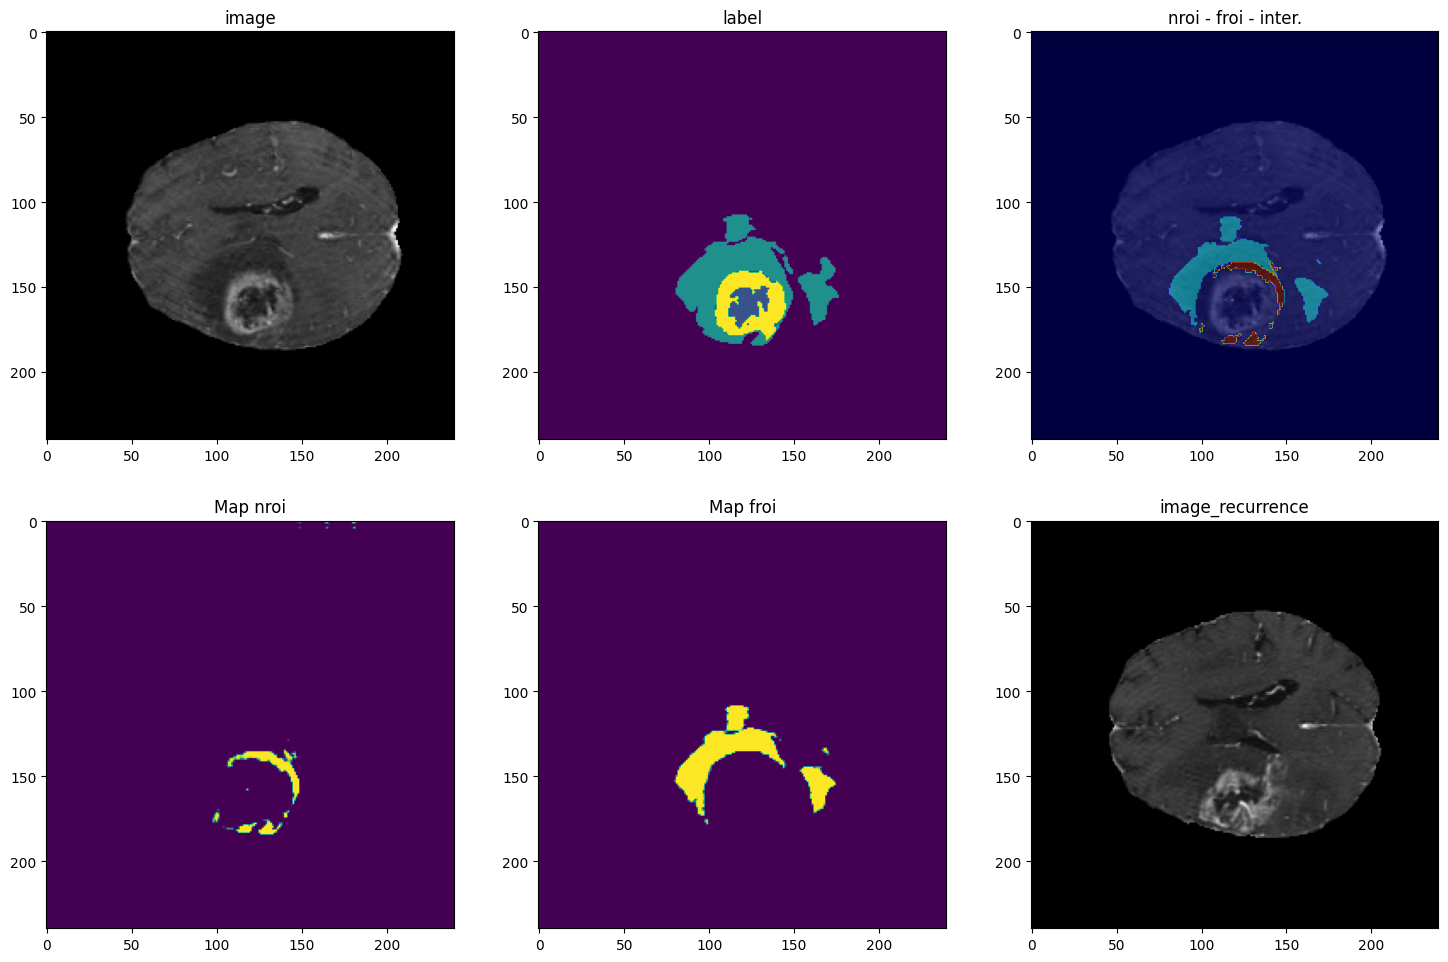

In [24]:
# Imprimir
# cases =['00036', '00042','00045', '00051' ]
serie=cases[n]
slice=90
imprimir_inferencia(f'{str(serie).zfill(5)}', seg_out, seg, slice=slice, recurrence=True)